In [2]:
import numpy as np
import torch
import numba as nb
from torch.utils import data
from dataloader.transform_3d import PadMultiViewImage, NormalizeMultiviewImage, \
    PhotoMetricDistortionMultiViewImage, RandomScaleImageMultiViewImage
from typing import List, Union
from torch import Tensor
import torch.nn.functional as F
import os
import numpy as np
from torch.utils import data
import yaml
import pickle
from pyquaternion import Quaternion

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [2]:
# load npy
vox_feat = np.load('/home/jovyan/TPVFormer/out/tpv_nerf_feat_pred/2024-01-16-10-52-08-TPVformer_w_NeRF_exp0/val_output/2024-01-16-10-52-08-TPVformer_w_NeRF_exp0/epoch_3/952cb0bcd89b4ca4b904cdcbbf595523/2468-b4b5e858cd9d4cf9bdb01098ea7d3c45_pred_vox_feat.npy')


In [17]:
vox_feat.max()

0.4485706

In [16]:
vox_feat[0,:,0,4,0].max()

0.062826306

In [19]:
np.mean(vox_feat, axis=1).max()

0.15658337

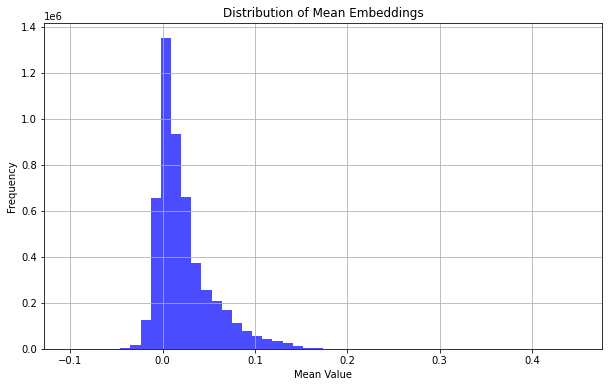

In [20]:
import matplotlib.pyplot as plt

flattened_embeddings = vox_feat.flatten()

# Plotting the distribution of these means
plt.figure(figsize=(10, 6))
plt.hist(flattened_embeddings, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Mean Embeddings')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

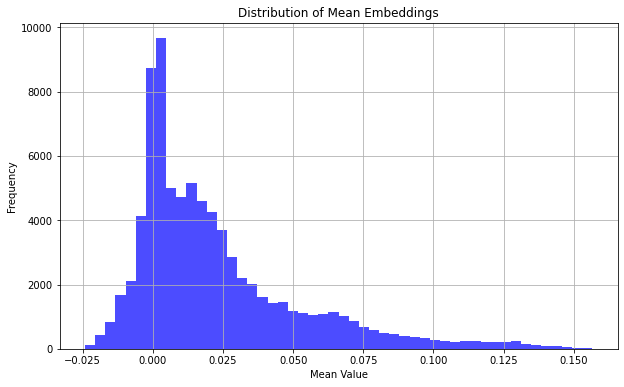

In [14]:
import matplotlib.pyplot as plt

# Calculating the mean across the dimension with 64 embeddings
# The resulting shape will be (1, 100, 100, 8)
mean_embeddings = np.mean(vox_feat, axis=1)

# Reshaping the result to a 2D array where each row represents one of the 80000 points
# The new shape will be (80000, 8)
# flatten
flattened_embeddings = mean_embeddings.flatten()

# Plotting the distribution of these means
plt.figure(figsize=(10, 6))
plt.hist(flattened_embeddings, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Mean Embeddings')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [3]:
import plotly.graph_objects as go
def vis_occ_plotly(
    vis_aabb: List[Union[int, float]],
    coords: np.array,
    colors: np.array,
    dynamic_coords: List[np.array] = None,
    dynamic_colors: List[np.array] = None,
    x_ratio: float = 1.0,
    y_ratio: float = 1.0,
    z_ratio: float = 0.125,
    size: int = 5,
    black_bg: bool = False,
    title: str = None,
) -> go.Figure:  # type: ignore
    fig = go.Figure()  # start with an empty figure

    # Add static trace
    static_trace = go.Scatter3d(
        x=coords[:, 0],
        y=coords[:, 1],
        z=coords[:, 2],
        mode="markers",
        marker=dict(
            size=size,
            color=colors,
            symbol="square",
        ),
    )
    fig.add_trace(static_trace)

    # Add temporal traces
    if dynamic_coords is not None:
        for i in range(len(dynamic_coords)):
            fig.add_trace(
                go.Scatter3d(
                    x=dynamic_coords[i][:, 0],
                    y=dynamic_coords[i][:, 1],
                    z=dynamic_coords[i][:, 2],
                    mode="markers",
                    marker=dict(
                        size=size,
                        color=dynamic_colors[i],
                        symbol="diamond",
                    ),
                )
            )
        steps = []
        for i in range(len(dynamic_coords)):
            step = dict(
                method="restyle",
                args=[
                    "visible",
                    [False] * (len(dynamic_coords) + 1),
                ],  # Include the static trace
                label="Second {}".format(i),
            )
            step["args"][1][0] = True  # Make the static trace always visible
            step["args"][1][i + 1] = True  # Toggle i'th temporal trace to "visible"
            steps.append(step)

        sliders = [
            dict(
                active=0,
                pad={"t": 1},
                steps=steps,
                font=dict(color="white") if black_bg else {},  # Update for font color
            )
        ]
        fig.update_layout(sliders=sliders)
    title_font_color = "white" if black_bg else "black"
    if not black_bg:
        fig.update_layout(
            scene=dict(
                xaxis=dict(
                    title="x",
                    showspikes=False,
                    range=[vis_aabb[0], vis_aabb[3]],
                ),
                yaxis=dict(
                    title="y",
                    showspikes=False,
                    range=[vis_aabb[1], vis_aabb[4]],
                ),
                zaxis=dict(
                    title="z",
                    showspikes=False,
                    range=[vis_aabb[2], vis_aabb[5]],
                ),
                aspectmode="manual",
                aspectratio=dict(x=x_ratio, y=y_ratio, z=z_ratio),
            ),
            margin=dict(r=0, b=10, l=0, t=10),
            hovermode=False,
            title=dict(
                text=title,
                font=dict(color=title_font_color),
                x=0.5,
                y=0.95,
                xanchor="center",
                yanchor="top",
            )
            if title
            else None,  # Title addition
        )
    else:
        fig.update_layout(
            scene=dict(
                xaxis=dict(
                    title="x",
                    showspikes=False,
                    range=[vis_aabb[0], vis_aabb[3]],
                    backgroundcolor="rgb(0, 0, 0)",
                    gridcolor="gray",
                    showbackground=True,
                    zerolinecolor="gray",
                    tickfont=dict(color="gray"),
                ),
                yaxis=dict(
                    title="y",
                    showspikes=False,
                    range=[vis_aabb[1], vis_aabb[4]],
                    backgroundcolor="rgb(0, 0, 0)",
                    gridcolor="gray",
                    showbackground=True,
                    zerolinecolor="gray",
                    tickfont=dict(color="gray"),
                ),
                zaxis=dict(
                    title="z",
                    showspikes=False,
                    range=[vis_aabb[2], vis_aabb[5]],
                    backgroundcolor="rgb(0, 0, 0)",
                    gridcolor="gray",
                    showbackground=True,
                    zerolinecolor="gray",
                    tickfont=dict(color="gray"),
                ),
                aspectmode="manual",
                aspectratio=dict(x=x_ratio, y=y_ratio, z=z_ratio),
            ),
            margin=dict(r=0, b=10, l=0, t=10),
            hovermode=False,
            paper_bgcolor="black",
            plot_bgcolor="rgba(0,0,0,0)",
            title=dict(
                text=title,
                font=dict(color=title_font_color),
                x=0.5,
                y=0.95,
                xanchor="center",
                yanchor="top",
            )
            if title
            else None,  # Title addition
        )
    return fig

In [4]:
def voxel_coords_to_world_coords(
    aabb_min: Union[Tensor, List[float]],
    aabb_max: Union[Tensor, List[float]],
    voxel_resolution: Union[Tensor, List[int]],
    points: Union[Tensor, List[float]] = None,
) -> Tensor:
    aabb_min = torch.tensor(aabb_min) if isinstance(aabb_min, List) else aabb_min
    aabb_max = torch.tensor(aabb_max) if isinstance(aabb_max, List) else aabb_max
    voxel_resolution = (
        torch.tensor(voxel_resolution)
        if isinstance(voxel_resolution, List)
        else voxel_resolution
    )

    if points is None:
        x, y, z = torch.meshgrid(
            torch.linspace(aabb_min[0], aabb_max[0], voxel_resolution[0]),
            torch.linspace(aabb_min[1], aabb_max[1], voxel_resolution[1]),
            torch.linspace(aabb_min[2], aabb_max[2], voxel_resolution[2]),
        )
        return torch.stack([x, y, z], dim=-1)
    else:
        points = torch.tensor(points) if isinstance(points, List) else points

        # Compute voxel size
        voxel_size = (aabb_max - aabb_min) / voxel_resolution

        # Convert voxel coordinates to world coordinates
        world_coords = aabb_min.to(points.device) + points * voxel_size.to(points.device)

        return world_coords

def world_coords_to_voxel_coords(
    point: Union[Tensor, List[float]],
    aabb_min: Union[Tensor, List[float]],
    aabb_max: Union[Tensor, List[float]],
    voxel_resolution: Union[Tensor, List[int]],
) -> Tensor:
    # Convert lists to tensors if necessary
    point = torch.tensor(point) if isinstance(point, List) else point
    aabb_min = torch.tensor(aabb_min) if isinstance(aabb_min, List) else aabb_min
    aabb_max = torch.tensor(aabb_max) if isinstance(aabb_max, List) else aabb_max
    voxel_resolution = (
        torch.tensor(voxel_resolution)
        if isinstance(voxel_resolution, List)
        else voxel_resolution
    )

    # Compute the size of each voxel
    voxel_size = (aabb_max - aabb_min) / voxel_resolution

    # Compute the voxel index for the given point
    voxel_idx = ((point - aabb_min) / voxel_size).long()

    return voxel_idx

In [5]:
with open('/home/jovyan/TPVFormer/data/nuscenes_infos_train_aug.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
from nuscenes.nuscenes import NuScenes

In [7]:
nusc = NuScenes(version='v1.0-trainval', dataroot='/home/jovyan/TPVFormer/data/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval...


: 

In [ ]:
img_metas = data['infos'][10]
grid_size = [100,100,8]

In [70]:
scene_token = img_metas['scene_token']
base_nerf_save_dir = "/lpai/volumes/perception/qyx/nusc_nerf/dino_feat"
base_nerf_save_scene_dir = os.path.join(base_nerf_save_dir, scene_token)
color_PCA_path = os.path.join(base_nerf_save_scene_dir, 'pca_reduction.npy')
color_PCA = torch.from_numpy(np.load(color_PCA_path))
nerf_meta_path = os.path.join(base_nerf_save_scene_dir, 'metadata.json')
import json
with open(nerf_meta_path, 'r') as f:
    nerf_meta = json.load(f)

In [71]:
nerf_dino_feat_path = img_metas['nerf_dino_feat_path']
nerf_voxel_coords_path = img_metas['nerf_voxel_coords_path']
nerf_dino_feat = torch.from_numpy(np.load(nerf_dino_feat_path))
nerf_voxel_coords = torch.from_numpy(np.load(nerf_voxel_coords_path))

In [72]:
max_bound = torch.Tensor([51.2,51.2,3])  # 51.2 51.2 3
min_bound = torch.Tensor([-51.2,-51.2,-5])  # -51.2 -51.2 -5

In [73]:
nerf_voxel_resolution_scene = img_metas['nerf_voxel_resolution']
nerf_aabb_min_scene = torch.Tensor(img_metas['nerf_aabb_min'])
nerf_aabb_max_scene = torch.Tensor(img_metas['nerf_aabb_max'])
lidar_to_first_nerf_ego_transform = torch.Tensor(img_metas['lidar_to_first_ego_transform'])

In [74]:
nerf_voxel_coords_world = voxel_coords_to_world_coords(nerf_aabb_min_scene, nerf_aabb_max_scene, nerf_voxel_resolution_scene, nerf_voxel_coords)

In [75]:
aabb_length_scene = nerf_aabb_max_scene - nerf_aabb_min_scene
#concat
aabb = torch.cat([nerf_aabb_min_scene, nerf_aabb_max_scene], dim=0)

In [78]:
nerf_world_coords_homo = torch.cat((nerf_voxel_coords_world, torch.ones(nerf_voxel_coords_world.shape[0], 1)), dim=1)

In [79]:
nerf_world_coords_extended_lidar_t_sample = (nerf_world_coords_homo @ torch.inverse(lidar_to_first_nerf_ego_transform).T)[:,:3]

In [80]:
# Create a mask for each condition
mask_x = (nerf_world_coords_extended_lidar_t_sample[:, 0] >= min_bound[0]) & (nerf_world_coords_extended_lidar_t_sample[:, 0] <= max_bound[0])
mask_y = (nerf_world_coords_extended_lidar_t_sample[:, 1] >= min_bound[1]) & (nerf_world_coords_extended_lidar_t_sample[:, 1] <= max_bound[1])
mask_z = (nerf_world_coords_extended_lidar_t_sample[:, 2] >= min_bound[2]) & (nerf_world_coords_extended_lidar_t_sample[:, 2] <= max_bound[2])

# Combine masks to identify rows that meet all conditions
mask = mask_x & mask_y & mask_z

# Apply the mask to filter the tensors
filtered_nerf_sample_world_coords = nerf_world_coords_extended_lidar_t_sample[mask]
filtered_nerf_sample_feats = nerf_dino_feat[mask]

In [81]:
filtered_nerf_sample_vox_coords = world_coords_to_voxel_coords(filtered_nerf_sample_world_coords, min_bound, max_bound, grid_size)

In [82]:
filtered_nerf_voxels_dino_feature_sample = torch.zeros((*grid_size, 64))
filtered_nerf_voxels_dino_feature_sample[filtered_nerf_sample_world_coords[...,0].long(),filtered_nerf_sample_world_coords[...,1].long(),filtered_nerf_sample_world_coords[...,2].long()] = filtered_nerf_sample_feats
filtered_nerf_voxels_dino_feature_sample = filtered_nerf_voxels_dino_feature_sample.permute(3,0,1,2) # (embed_dim, x, y, z)

In [83]:
aabb_length = max_bound - min_bound

In [84]:
figure_white = vis_occ_plotly(vis_aabb=np.array([-51.2,-51.2,-5,51.2,51.2,3]), coords=filtered_nerf_sample_world_coords.cpu().numpy(), colors=torch.ones((filtered_nerf_sample_world_coords.shape[0], 3)).cpu().numpy(), x_ratio=1, y_ratio=(aabb_length[1] / aabb_length[0]).item(), z_ratio=(aabb_length[2] / aabb_length[0]).item(), size=3, black_bg=True, title="Debug NeRF Feat", )

In [92]:
# Retrieve the sample data
sample = nusc.get('sample', img_metas['token'])

# Get the LiDAR data token
lidar_token = sample['data']['LIDAR_TOP']

# Load LiDAR data
lidar_data = nusc.get('sample_data', lidar_token)
lidar_filepath = nusc.get_sample_data_path(lidar_token)

# Load the point cloud
from nuscenes.utils.data_classes import LidarPointCloud
lidar_points = LidarPointCloud.from_file(lidar_filepath).points.T

In [93]:
mask = (
    (lidar_points[:, 0] >= -51.2) & (lidar_points[:, 0] <= 51.2) &
    (lidar_points[:, 1] >= -51.2) & (lidar_points[:, 1] <= 51.2) &
    (lidar_points[:, 2] >= -5) & (lidar_points[:, 2] <= 3)
)
filtered_lidar_points = lidar_points[mask, :3]  # Exclude the reflectance

# Convert filtered_lidar_points to a PyTorch tensor and augment it
filtered_lidar_points_tensor = torch.tensor(filtered_lidar_points)

In [97]:
red_color = torch.tensor([[1, 0, 0]] * filtered_lidar_points_tensor.shape[0])
locations = torch.cat([filtered_nerf_sample_world_coords, filtered_lidar_points_tensor], dim=0)
colors_features = torch.cat([torch.ones((filtered_nerf_sample_world_coords.shape[0], 3)), red_color], dim=0)

In [101]:
figure_white_lidar = vis_occ_plotly(vis_aabb=np.array([-51.2,-51.2,-5,51.2,51.2,3]), coords=locations.cpu().numpy(), colors=colors_features.numpy(), x_ratio=1, y_ratio=(aabb_length[1] / aabb_length[0]).item(), z_ratio=(aabb_length[2] / aabb_length[0]).item(), size=3, black_bg=True, title="Debug NeRF Feat", )

In [102]:
figure_white_lidar.write_html(f"/home/jovyan/TPVFormer/debug_nerf_sample_lidar.html")

In [85]:
colors_features = filtered_nerf_sample_feats @ color_PCA
colors_features = (colors_features - torch.Tensor(nerf_meta['color_min'])) / (torch.Tensor(nerf_meta['color_max']) - torch.Tensor(nerf_meta['color_min']))
colors_features = torch.clamp(colors_features, 0, 1)

figure_PCA_color = vis_occ_plotly(vis_aabb=np.array([-51.2,-51.2,-5,51.2,51.2,3]), coords=filtered_nerf_sample_world_coords.cpu().numpy(), colors=colors_features.numpy(), x_ratio=1, y_ratio=(aabb_length[1] / aabb_length[0]).item(), z_ratio=(aabb_length[2] / aabb_length[0]).item(), size=3, black_bg=True, title="Debug NeRF Feat", )

In [86]:
figure_PCA_color.write_html(f"/home/jovyan/TPVFormer/debug_nerf_sample_PCA_color.html")

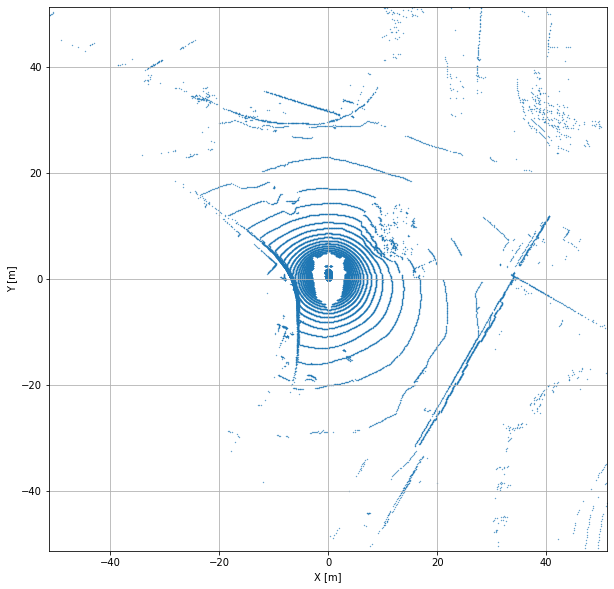

In [91]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
import matplotlib.pyplot as plt
import numpy as np

# Initialize the NuScenes object
# Replace 'path_to_nuscenes_data' with your actual data path

# Find the desired scene
scene_token = 'd3d94f2ce3dc4db4b3ba6f4aa81c3987'
scene = nusc.get('scene', scene_token)

# Get the first sample of the scene
first_sample_token = scene['first_sample_token']
sample = nusc.get('sample', first_sample_token)

# BEV map function
def draw_bev_map(sample_data_token, axes_limit=51.2):
    # Get sample data
    sample_data = nusc.get('sample_data', sample_data_token)
    sensor_token = sample_data['calibrated_sensor_token']
    sensor = nusc.get('calibrated_sensor', sensor_token)

    # Load point cloud
    pc = LidarPointCloud.from_file(nusc.get_sample_data_path(sample_data_token))

    # Convert quaternion to rotation matrix
    rotation_matrix = Quaternion(sensor['rotation']).rotation_matrix

    pc.rotate(rotation_matrix)
    pc.translate(np.array(sensor['translation']))

    # Transform to BEV space
    points = view_points(pc.points[:3, :], np.eye(4), normalize=False)
    points = points.T

    # Filter points to a certain area for better visualization
    mask = np.ones(points.shape[0], dtype=bool)
    mask &= points[:, 0] > -axes_limit
    mask &= points[:, 0] < axes_limit
    mask &= points[:, 1] > -axes_limit
    mask &= points[:, 1] < axes_limit

    points = points[mask]

    # Plot BEV map with x and y swapped
    plt.scatter(points[:, 1], points[:, 0], s=0.1)  # Swapping x and y here
    plt.xlim(-axes_limit, axes_limit)
    plt.ylim(-axes_limit, axes_limit)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.grid(True)

# Draw the BEV map for the first LIDAR sample in the scene
lidar_token = sample['data']['LIDAR_TOP']
plt.figure(figsize=(10, 10))
draw_bev_map(lidar_token)
plt.show()


In [81]:
transformation_matrix = torch.tensor(
[[-1.94867556e-02,  9.99789967e-01,  6.34724044e-03, 6.31296036e+01],
[-9.99741356e-01, -1.95594759e-02,  1.16038330e-02, -1.68145031e+00],
[ 1.17255445e-02, -6.11947771e-03,  9.99912528e-01, 2.43236835e+00],
[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]], dtype=torch.float32)

In [92]:
(torch.Tensor([0,0,0,1]) @ transformation_matrix.T)

tensor([63.1296, -1.6815,  2.4324,  1.0000])

In [96]:
lidar_to_first_nerf_ego_transform @ torch.Tensor([10,0,0,1])

tensor([ 1.2251, -9.9919,  1.7708,  1.0000])

In [74]:
torch.Tensor([20,0,0,1]) @ lidar_to_first_nerf_ego_transform

tensor([ 0.2491, 19.9923,  0.4948, 23.0102])

In [102]:
def transform_matrix(translation, rotation):
    """Compute transformation matrix given translation and rotation (in quaternion)."""
    transform = np.eye(4)
    transform[:3, :3] = Quaternion(rotation).rotation_matrix
    transform[:3, 3] = translation
    return transform

def get_global_to_ego_matrix(ego_pose):
    ego_to_global = np.eye(4)
    ego_to_global[:3, :3] = Quaternion(ego_pose["rotation"]).rotation_matrix
    ego_to_global[:3, 3] = ego_pose["translation"]
    return np.linalg.inv(ego_to_global)

def get_transformation_to_first_ego(nusc, sample_token):
    sample = nusc.get('sample', sample_token)
    scene_token = sample['scene_token']

    # Get the first sample of the scene
    scene = nusc.get('scene', scene_token)
    first_sample_token = scene["first_sample_token"]
    first_sample = nusc.get("sample", first_sample_token)
    current_camera_data_token = first_sample["data"]["CAM_FRONT"]
    camera_data_dict = nusc.get("sample_data", current_camera_data_token)
    initial_ego_pose = nusc.get("ego_pose", camera_data_dict["ego_pose_token"])
    global_to_initial_ego_matrix = get_global_to_ego_matrix(initial_ego_pose)

    # Get the lidar_top data
    current_lidar_data_token = sample["data"]["LIDAR_TOP"]
    current_lidar_data = nusc.get("sample_data", current_lidar_data_token)
    # 1. lidar --> current ego pose
    lidar_intrinsic = nusc.get(
        "calibrated_sensor", current_lidar_data["calibrated_sensor_token"]
    )
    lidar_to_ego = np.eye(4)
    lidar_to_ego[:3, :3] = Quaternion(
        lidar_intrinsic["rotation"]
    ).rotation_matrix
    lidar_to_ego[:3, 3] = np.array(lidar_intrinsic["translation"])
    # 2. current ego pose --> global pose
    # Construct the transformation matrix for this timestamp
    ego_pose = nusc.get("ego_pose", current_lidar_data["ego_pose_token"])
    ego_to_global_matrix = np.eye(4)
    ego_to_global_matrix[:3, :3] = Quaternion(
        ego_pose["rotation"]
    ).rotation_matrix
    ego_to_global_matrix[:3, 3] = np.array(ego_pose["translation"])
    # 3. global pose --> ego pose at t=0
    return global_to_initial_ego_matrix, ego_to_global_matrix, lidar_to_ego, global_to_initial_ego_matrix @ ego_to_global_matrix @ lidar_to_ego

In [98]:
img_metas['token']

'e93e98b63d3b40209056d129dc53ceee'

In [103]:
global_to_initial_ego_matrix, ego_to_global_matrix, lidar_to_ego, lidar_to_first_nerf_ego_transform = get_transformation_to_first_ego(nusc, img_metas['token'])

In [127]:
torch.Tensor(global_to_initial_ego_matrix) @ torch.Tensor(ego_to_global_matrix) @ torch.Tensor([0,0,0,1])

tensor([ 0.1560, -0.0016, -0.0036,  1.0000])